# Project 4: West Nile Virus in the City of Chicago

Arash Ghafouri, Puneet Kollipara, Hector Martinez, Michael Schillawski, Ken Yale

9 March 2018

Data Science Immersive, General Assembly

# Scoring

## 1. Python Setup

In [1]:
%%javascript
$('.nbp-app-bar').toggle()

<IPython.core.display.Javascript object>

In [2]:
import sys
import logging
import datetime
from time import gmtime, strftime
#sys.stdout=open("train_log.txt","w")

print('starting imports...')
import matplotlib.pyplot as plt
import os
import pickle
import multiprocessing
import numpy as np
import pandas as pd
import seaborn as sns
import pandas_profiling as pdp

from haversine import haversine
from joblib import Parallel, delayed

%matplotlib inline

starting imports...


/Users/mjschillawski/anaconda3/lib/python3.6/site-packages/pandas_profiling/plot.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/mjschillawski/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/mjschillawski/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/mjschillawski/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/mjschillawski/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/mjschillawski/anaconda3/lib/python3.6/site-pac

In [3]:
sns.set_style('whitegrid')

## 2. Modeling/Scoring Environment Setup

### 2.1 Imports

In [4]:
print('modeling...')

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

modeling...


### 2.2 Function Definition

In [5]:
def aucroc(probas,y_true,step=0.01):  #,metric='sensitivity',threshold=95
    obs = y_true.values

    sensitivity = []
    specificity = []

    for t in np.arange(0,1,step): #iterate through each step of classification threshold
        
        TP = 0
        FP = 0
        FN = 0
        TN = 0
        
        for i in range(len(y_true)): #iterate through each observation
            predictions = probas[:,1] > t #only predicted class probability

            ##classify each based on whether correctly predicted
            if predictions[i] == 1 and obs[i] == 1:
                TP += 1
            elif predictions[i] == 0 and obs[i] == 1:
                FN += 1
            elif predictions[i] == 1 and obs[i] == 0:
                FP += 1
            elif predictions[i] == 0 and obs[i] == 0:
                TN += 1
        
        #calculate each metric
        sens = TP / (TP + FN)
        spec = TN / (TN + FP)

        #append all metrics to list 
        sensitivity.append(sens)
        specificity.append(1 - spec)

    #graph sens vs spec curve
    plt.rcParams['font.size'] = 14
    plt.plot(specificity,sensitivity)
    plt.plot([0,1],[0,1], color='black', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('Receiver Operating Characteristic',fontsize='xx-large')
    plt.xlabel("False Positive Rate",fontsize='x-large')
    plt.ylabel("True Positive Rate",fontsize='x-large')
    plt.show()
    
    return sensitivity,specificity

### 2.3 Read in models

In [6]:
import pickle
os.chdir('/Users/mjschillawski/Google Drive/Data/generalassembly/projects/west_nile_virus/assets/gradient_boost_pickles')

pickle_jar = [file for file in os.listdir() if '.pickle' in file]

gb_models = pickle.load(open(pickle_jar[0],'rb'))
gb_scores = pickle.load(open(pickle_jar[1],'rb'))
gb_probas = pickle.load(open(pickle_jar[2],'rb'))
gb_preds = pickle.load(open(pickle_jar[3],'rb'))
gb_metrics = pickle.load(open(pickle_jar[4],'rb'))
X_trains = pickle.load(open(pickle_jar[5],'rb'))
X_tests = pickle.load(open(pickle_jar[6],'rb'))
y_trains = pickle.load(open(pickle_jar[7],'rb'))
y_tests = pickle.load(open(pickle_jar[8],'rb'))

## 3. Model Evaluation

### 3.1 Recovery

In [5]:
# recover best estimators
gb_models

{0: GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.01, loss='deviance', max_depth=4,
               max_features=1.0, max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=100, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=1000,
               presort='auto', random_state=20180309, subsample=1.0,
               verbose=1, warm_start=False),
 1: GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.01, loss='deviance', max_depth=4,
               max_features=0.3, max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=100, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=1000,
               presort='auto', random_state=20180309, subsample=1.0,
               verbose=1, warm_start=False),
 2: GradientBoosting

In [6]:
# recover accuracy scores
gb_scores

{0: 0.94791185356317753,
 1: 0.94477184068615305,
 2: 0.94724527818160098,
 3: 0.95038907841874809,
 4: 0.9502192298840193,
 5: 0.97342875538606299,
 6: 0.95038907841874809,
 7: 0.9502192298840193,
 8: 0.97342875538606299,
 9: 0.94439776604019843}

In [7]:
# recover probas
gb_probas

{0: array([[ 0.99870943,  0.00129057],
        [ 0.85448866,  0.14551134],
        [ 0.80368248,  0.19631752],
        ..., 
        [ 0.770746  ,  0.229254  ],
        [ 0.98304105,  0.01695895],
        [ 0.78232477,  0.21767523]]), 1: array([[ 0.99878096,  0.00121904],
        [ 0.89676783,  0.10323217],
        [ 0.82814234,  0.17185766],
        ..., 
        [ 0.83686652,  0.16313348],
        [ 0.97806919,  0.02193081],
        [ 0.78553639,  0.21446361]]), 2: array([[ 0.99899174,  0.00100826],
        [ 0.88305438,  0.11694562],
        [ 0.80218189,  0.19781811],
        ..., 
        [ 0.84507204,  0.15492796],
        [ 0.983274  ,  0.016726  ],
        [ 0.81401417,  0.18598583]]), 3: array([[ 0.99887635,  0.00112365],
        [ 0.85715744,  0.14284256],
        [ 0.82587231,  0.17412769],
        ..., 
        [ 0.81190465,  0.18809535],
        [ 0.98391652,  0.01608348],
        [ 0.82236362,  0.17763638]]), 4: array([[ 0.99880492,  0.00119508],
        [ 0.88919501,  0.

In [8]:
# recover class predictions 
gb_preds

{0: array([0, 0, 0, ..., 0, 0, 0]),
 1: array([0, 0, 0, ..., 0, 0, 0]),
 2: array([0, 0, 0, ..., 0, 0, 0]),
 3: array([0, 0, 0, ..., 0, 0, 0]),
 4: array([0, 0, 0, ..., 0, 0, 0]),
 5: array([0, 0, 0, ..., 0, 0, 0]),
 6: array([0, 0, 0, ..., 0, 0, 0]),
 7: array([0, 0, 0, ..., 0, 0, 0]),
 8: array([0, 0, 0, ..., 0, 0, 0]),
 9: array([0, 0, 0, ..., 0, 0, 0])}

In [9]:
# recover metrics
gb_metrics

{0: (0.93826189539913485,
  0.35294117647058826,
  '             precision    recall  f1-score   support\n\n          0       0.94      1.00      0.97      2391\n          1       0.35      0.04      0.07       152\n\navg / total       0.91      0.94      0.91      2543\n'),
 1: (0.94022807707432166,
  0.5,
  '             precision    recall  f1-score   support\n\n          0       0.94      1.00      0.97      2391\n          1       0.50      0.04      0.07       152\n\navg / total       0.92      0.94      0.92      2543\n'),
 2: (0.93747542272906015,
  0.29411764705882354,
  '             precision    recall  f1-score   support\n\n          0       0.94      0.99      0.97      2391\n          1       0.29      0.03      0.06       152\n\navg / total       0.90      0.94      0.91      2543\n'),
 3: (0.93826189539913485,
  0.36842105263157893,
  '             precision    recall  f1-score   support\n\n          0       0.94      0.99      0.97      2391\n          1       0.37    

### 3.2 AUC-ROC

#### Gradient Boost Classifier: 1 week/0.5 mile spray

In [13]:
X_tests[0].columns

Index(['Latitude', 'Longitude', 'dayofyear', 'Species_CULEX ERRATICUS',
       'Species_CULEX PIPIENS', 'Species_CULEX PIPIENS/RESTUANS',
       'Species_CULEX RESTUANS', 'Species_CULEX SALINARIUS',
       'Species_CULEX TARSALIS', 'Species_CULEX TERRITANS', 'Tmax', 'Tmin',
       'Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Depth',
       'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed', '1week_halfmile'],
      dtype='object')

0.819327962315


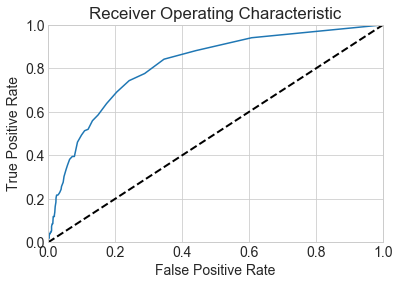

In [15]:
print(roc_auc_score(y_tests[0],gb_probas[0][:,1]))
   
aucroc(gb_probas[0],y_tests[0])

#### Gradient Boost Classifier: 1 week/1 mile spray

In [20]:
X_tests[1].columns

Index(['Latitude', 'Longitude', 'dayofyear', 'Species_CULEX ERRATICUS',
       'Species_CULEX PIPIENS', 'Species_CULEX PIPIENS/RESTUANS',
       'Species_CULEX RESTUANS', 'Species_CULEX SALINARIUS',
       'Species_CULEX TARSALIS', 'Species_CULEX TERRITANS', 'Tmax', 'Tmin',
       'Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Depth',
       'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed', '1week_1mile'],
      dtype='object')

0.826252228753


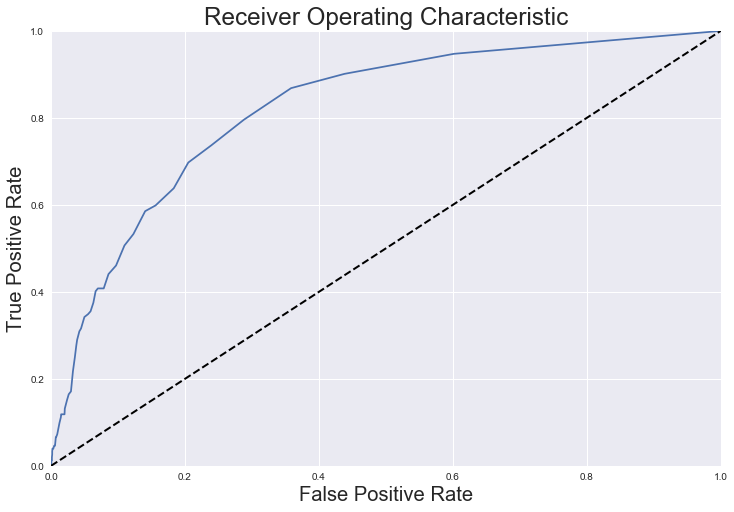

In [159]:
print(roc_auc_score(y_tests[1],gb_probas[1][:,1]))
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
senst, specf = aucroc(gb_probas[1],y_tests[1])

In [268]:
specf[5]

0.23923044751150147

In [269]:
senst[5]

0.7368421052631579

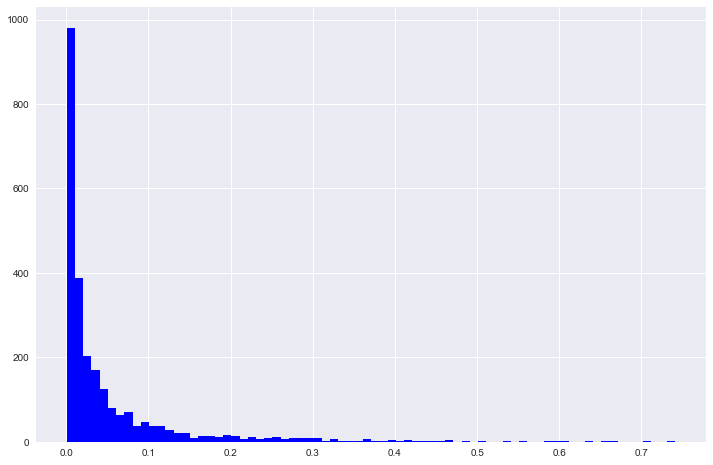

In [56]:
sns.set(style='darkgrid')

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

pr_max = gb_probas[1][:,1].max()
pr_min = gb_probas[1][:,1].min()
pr_range = pr_max - pr_min
pr_bins = int(round(100*pr_range))

_ = plt.hist(gb_probas[1][:,1],color='b',bins=pr_bins)
# _ = plt.xticks(np.arange(0,110,10),fontsize='large')
# _ = plt.xlabel('Post Percentile',fontsize='x-large')
# _ = plt.yticks(fontsize='large')
# _ = plt.ylabel('Number of Comments',fontsize='x-large')
# _ = plt.axvline(75,color='r')
# _ = plt.text(68,1350,'75%',fontsize='xx-large')

# _ = plt.title('Commenting Begins to Increase Drastically at the 75th percentile',fontsize='xx-large')

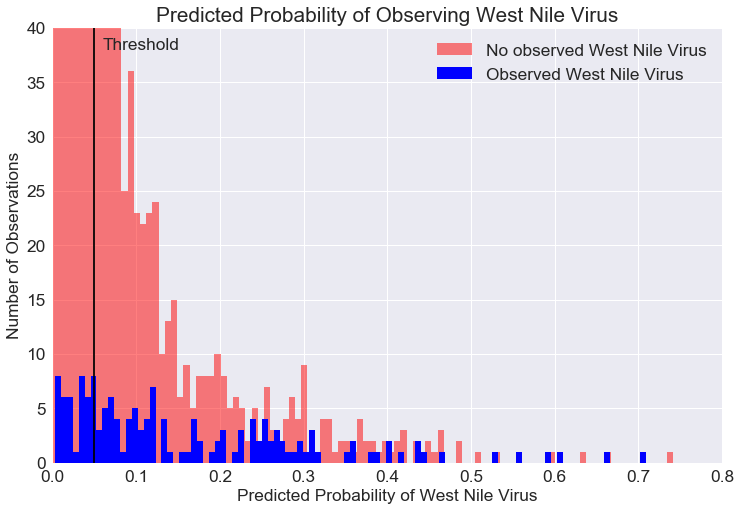

In [154]:
sns.set(style='darkgrid')

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

pr_max = data[data['prbs']>.06]['prbs'].max()
pr_min = data[data['prbs']>.06]['prbs'].min()
pr_range = pr_max - pr_min
pr_bins = int(round(100*pr_range))

_ = ax.set_xlim([0,.8])
_ = ax.set_ylim([0,40])
#https://stackoverflow.com/questions/3777861/setting-y-axis-limit-in-matplotlib

#https://stackoverflow.com/questions/21654635/scatter-plots-in-pandas-pyplot-how-to-plot-by-category
_ = plt.hist(data[data['ys']<=0]['prbs'],color='red',alpha=.5,bins=100,label='No observed West Nile Virus')
_ = plt.hist(data[data['ys']>=1]['prbs'],color='blue',alpha=1,bins=100,label='Observed West Nile Virus')
_ = plt.axvline(.05,color='black')

_ = plt.title('Predicted Probability of Observing West Nile Virus',fontsize='xx-large')
_ = plt.xticks(fontsize='x-large')
_ = plt.xlabel('Predicted Probability of West Nile Virus',fontsize='x-large')
_ = plt.yticks(fontsize='x-large')
_ = plt.ylabel('Number of Observations',fontsize='x-large')
_ = plt.legend(fontsize='x-large')
_ = plt.text(0.06,38,'Threshold',fontsize='x-large')

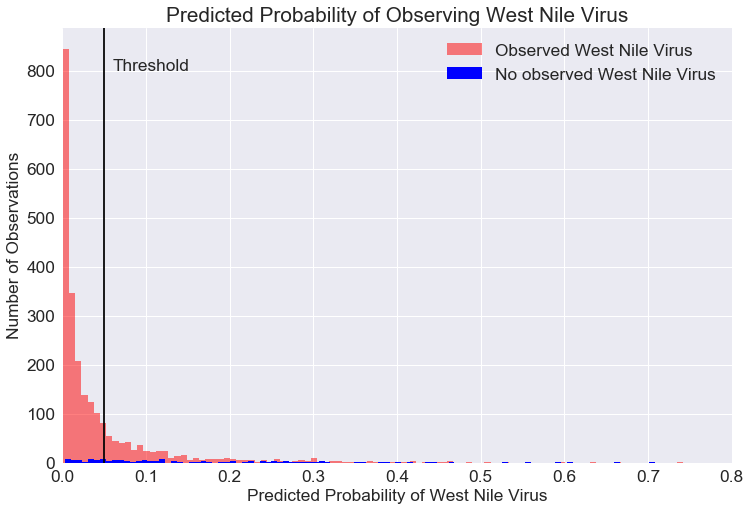

In [148]:
sns.set(style='darkgrid')

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

pr_max = data[data['prbs']>.06]['prbs'].max()
pr_min = data[data['prbs']>.06]['prbs'].min()
pr_range = pr_max - pr_min
pr_bins = int(round(100*pr_range))

_ = ax.set_xlim([0,.8])
#_ = ax.set_ylim([0,100])

_ = plt.hist(data[data['ys']<=0]['prbs'],color='red',alpha=.5,bins=100,label='No observed West Nile Virus')
_ = plt.hist(data[data['ys']>=1]['prbs'],color='blue',alpha=1,bins=100,label='Observed West Nile Virus')
_ = plt.axvline(.05,color='black')

_ = plt.title('Predicted Probability of Observing West Nile Virus',fontsize='xx-large')
_ = plt.xticks(fontsize='x-large')
_ = plt.xlabel('Predicted Probability of West Nile Virus',fontsize='x-large')
_ = plt.yticks(fontsize='x-large')
_ = plt.ylabel('Number of Observations',fontsize='x-large')
_ = plt.legend(fontsize='x-large')
_ = plt.text(0.06,800,'Threshold',fontsize='x-large')

In [181]:
features = pd.DataFrame(gb_models[1].feature_importances_,
                      index=X_trains[1].columns)
features.rename(columns={0:'importance'},inplace=True)

features = features.sort_values('importance',ascending=False)

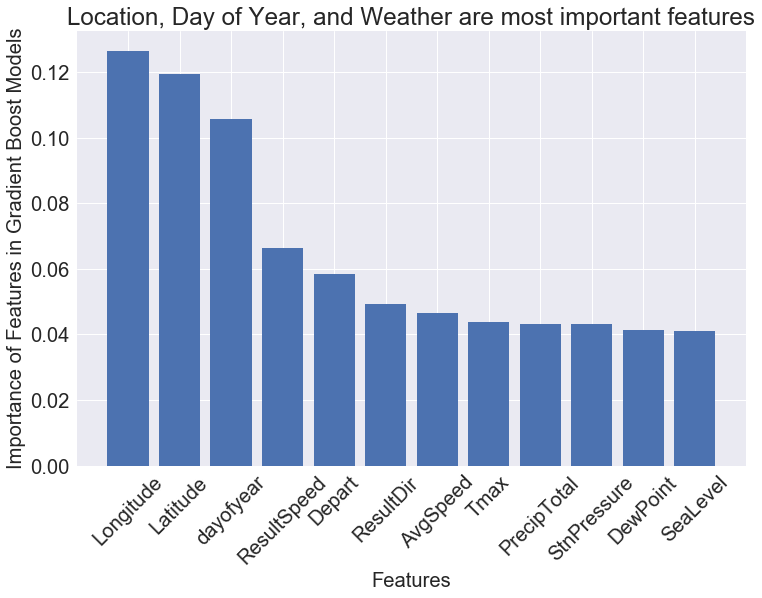

In [265]:
# Plot the feature importances of the forest
fig = plt.figure(figsize=(12,8))

_ = plt.title("Location, Day of Year, and Weather are most important features",fontsize='xx-large')
_ = plt.bar(range(0,12,1), features['importance'].iloc[:12], align="center")

_ = plt.xlabel('Features',fontsize='x-large')
_ = plt.ylabel('Importance of Features in Gradient Boost Models',fontsize='x-large')

_ = plt.xticks(range(0,12,1),features.index,rotation=45,fontsize='x-large')
_ = plt.yticks(fontsize='x-large')

_ = plt.xlim([-1, 12])
plt.show()


In [223]:
xtest = X_tests[1]
ytest = pd.DataFrame(y_tests[1])
gbprobs = pd.DataFrame(gb_probas[1][:,1])
test = pd.concat([xtest,ytest],axis=1,join='inner')
cols = list(test.columns.values)

2543


In [232]:
cols.append('probas')
testscores = pd.merge(test.reset_index(),gbprobs,how='inner',left_index=True,right_index=True)
testscores.set_index('index',inplace=True)
testscores.rename(columns={0:'probas'},inplace=True)
print(len(testscores))

2543


In [251]:
testscores['1week_1mile'].value_counts()

0    2333
1     210
Name: 1week_1mile, dtype: int64

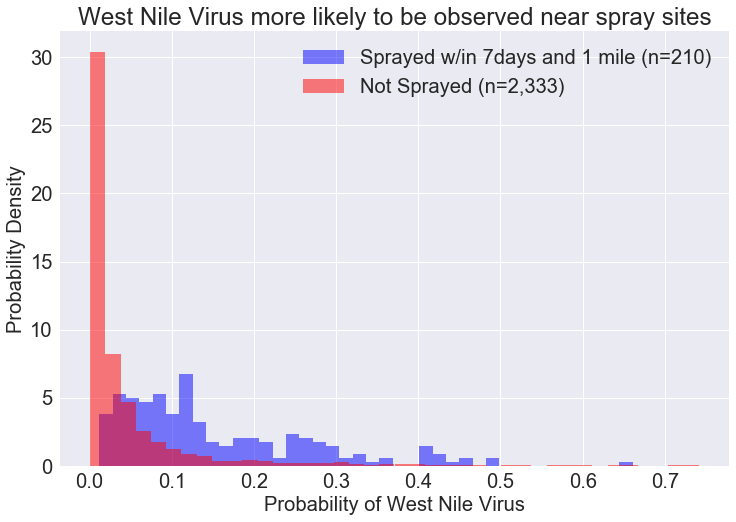

In [264]:
fig = plt.figure(figsize=(12,8))

_ = plt.hist(testscores[testscores['1week_1mile']==1]['probas'],
         color='blue',alpha=0.5,density=True,bins=40,label='Sprayed w/in 7days and 1 mile (n=210)')
_ = plt.hist(testscores[testscores['1week_1mile']==0]['probas'],
         color='red',alpha=0.5,density=True,bins=40,label='Not Sprayed (n=2,333)')

_ = plt.title("West Nile Virus more likely to be observed near spray sites",fontsize='xx-large')

_ = plt.xlabel('Probability of West Nile Virus',fontsize='x-large')
_ = plt.ylabel('Probability Density',fontsize='x-large')

_ = plt.xticks(fontsize='x-large')
_ = plt.yticks(fontsize='x-large')

_ = plt.legend(fontsize='x-large')

In [250]:
pd.crosstab(testscores['1week_1mile'],testscores['WnvPresent'],normalize='index',margins=True)

WnvPresent,0,1
1week_1mile,,
0,0.947707,0.052293
1,0.857143,0.142857
All,0.940228,0.059772


In [253]:
testscores.groupby(['1week_1mile'])['probas'].mean()

1week_1mile
0    0.04278
1    0.15230
Name: probas, dtype: float64

In [254]:
from scipy.stats import ttest_ind

ttest_ind(testscores[testscores['1week_1mile']==1]['probas'],
         testscores[testscores['1week_1mile']==0]['probas'])

Ttest_indResult(statistic=18.514728519021808, pvalue=6.8272612067260508e-72)

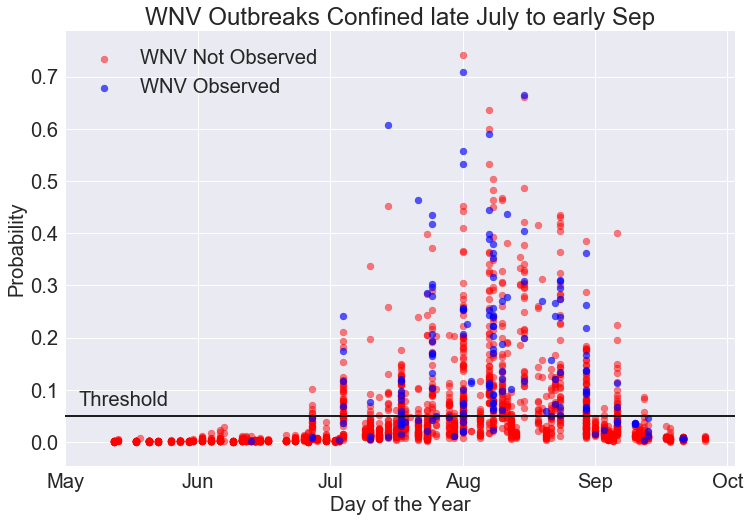

In [293]:
fig = plt.figure(figsize=(12,8))

_ = plt.scatter(testscores[testscores['WnvPresent']==0]['dayofyear'],
            testscores[testscores['WnvPresent']==0]['probas'],color='red',alpha=.5,
            label='WNV Not Observed')

_ = plt.scatter(testscores[testscores['WnvPresent']==1]['dayofyear'],
            testscores[testscores['WnvPresent']==1]['probas'],color='blue',alpha=.65,
            label='WNV Observed')


_ = plt.title("WNV Outbreaks Confined late July to early Sep",fontsize='xx-large')

_ = plt.xlabel('Day of the Year',fontsize='x-large')
_ = plt.ylabel('Probability',fontsize='x-large')

_ = plt.xticks(range(137,289,30),
               ['May','Jun','Jul','Aug','Sep','Oct'],
               fontsize='x-large')
_ = plt.yticks(fontsize='x-large')

_ = plt.axhline(.05,color='black')
_ = plt.legend(fontsize='x-large')
_ = plt.text(140,.07,'Threshold',fontsize='x-large')


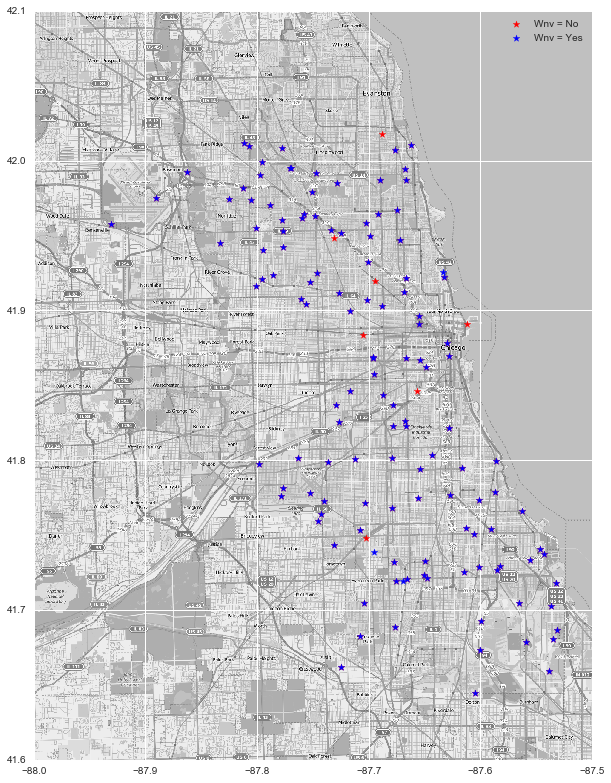

In [308]:
mapdata = np.loadtxt('/Users/mjschillawski/Google Drive/Data/generalassembly/projects/west_nile_virus/assets/input/mapdata_copyright_openstreetmap_contributors.txt')

#traps = pd.read_csv('./train.csv')[['Date', 'Trap','Longitude', 'Latitude', 'WnvPresent']]

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(10,14))
plt.imshow(mapdata,
          cmap=plt.get_cmap('gray'),
          extent=lon_lat_box,
          aspect=aspect)

traps1 = testscores[testscores['probas']>0.05][['Latitude','Longitude','probas']]
traps0 = testscores[testscores['probas']<=0.05][['Latitude','Longitude','probas']]

traps1 = traps1[['Longitude', 'Latitude']].drop_duplicates().values
traps0 = traps0[['Longitude', 'Latitude']].drop_duplicates().values

plt.scatter(traps0[:,0], traps0[:,1], color='red', marker='*', alpha=1, label='Wnv = No');
plt.scatter(traps1[:,0], traps1[:,1], color='blue', marker='*', alpha=1, label='Wnv = Yes');
plt.legend();

#plt.savefig('trap_map.png');

In [309]:
X_trains[1].columns

Index(['Latitude', 'Longitude', 'dayofyear', 'Species_CULEX ERRATICUS',
       'Species_CULEX PIPIENS', 'Species_CULEX PIPIENS/RESTUANS',
       'Species_CULEX RESTUANS', 'Species_CULEX SALINARIUS',
       'Species_CULEX TARSALIS', 'Species_CULEX TERRITANS', 'Tmax', 'Tmin',
       'Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Depth',
       'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed', '1week_1mile'],
      dtype='object')

#### Gradient Boost Classifier: 1 week/5 mile spray

In [40]:
X_tests[2].columns

Index(['Latitude', 'Longitude', 'dayofyear', 'Species_CULEX ERRATICUS',
       'Species_CULEX PIPIENS', 'Species_CULEX PIPIENS/RESTUANS',
       'Species_CULEX RESTUANS', 'Species_CULEX SALINARIUS',
       'Species_CULEX TARSALIS', 'Species_CULEX TERRITANS', 'Tmax', 'Tmin',
       'Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Depth',
       'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed', '1week_5mile'],
      dtype='object')

0.821592484977


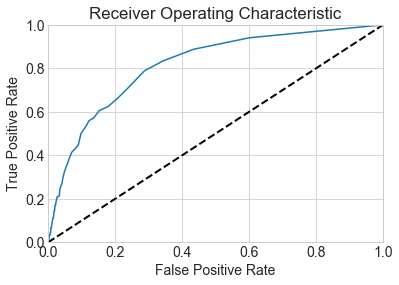

In [39]:
print(roc_auc_score(y_tests[2],gb_probas[2][:,1]))
   
aucroc(gb_probas[2],y_tests[2])

#### Gradient Boost Classifier: 1 month/0.5 mile spray

In [37]:
X_tests[3].columns

Index(['Latitude', 'Longitude', 'dayofyear', 'Species_CULEX ERRATICUS',
       'Species_CULEX PIPIENS', 'Species_CULEX PIPIENS/RESTUANS',
       'Species_CULEX RESTUANS', 'Species_CULEX SALINARIUS',
       'Species_CULEX TARSALIS', 'Species_CULEX TERRITANS', 'Tmax', 'Tmin',
       'Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Depth',
       'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed', '1month_halfmile'],
      dtype='object')

0.82187039116


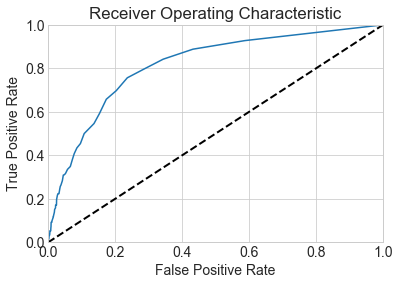

In [38]:
print(roc_auc_score(y_tests[3],gb_probas[3][:,1]))
   
aucroc(gb_probas[3],y_tests[3])

#### Gradient Boost Classifier: 1 month/1 mile spray

In [36]:
X_tests[4].columns

Index(['Latitude', 'Longitude', 'dayofyear', 'Species_CULEX ERRATICUS',
       'Species_CULEX PIPIENS', 'Species_CULEX PIPIENS/RESTUANS',
       'Species_CULEX RESTUANS', 'Species_CULEX SALINARIUS',
       'Species_CULEX TARSALIS', 'Species_CULEX TERRITANS', 'Tmax', 'Tmin',
       'Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Depth',
       'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed', '1month_1mile'],
      dtype='object')

0.824562779282


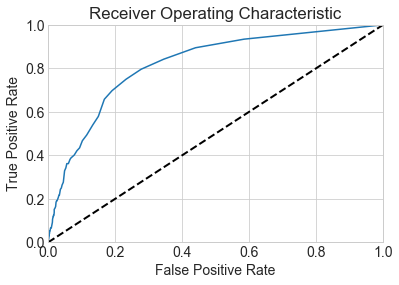

In [21]:
print(roc_auc_score(y_tests[4],gb_probas[4][:,1]))
   
aucroc(gb_probas[4],y_tests[4])

#### Gradient Boost Classifier: 1 month/5 mile spray

In [34]:
X_tests[5].columns

Index(['Latitude', 'Longitude', 'dayofyear', 'Species_CULEX ERRATICUS',
       'Species_CULEX PIPIENS', 'Species_CULEX PIPIENS/RESTUANS',
       'Species_CULEX RESTUANS', 'Species_CULEX SALINARIUS',
       'Species_CULEX TARSALIS', 'Species_CULEX TERRITANS', 'Tmax', 'Tmin',
       'Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Depth',
       'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed', '1month_5mile'],
      dtype='object')

0.819327962315


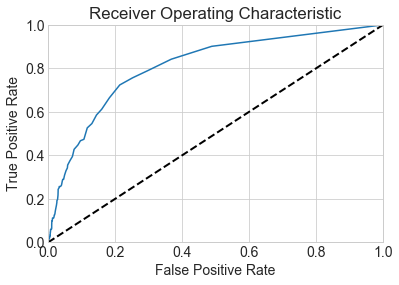

In [35]:
print(roc_auc_score(y_tests[5],gb_probas[0][:,1]))
   
aucroc(gb_probas[5],y_tests[5])

#### Gradient Boost Classifier: 1 quarter/0.5 mile spray

In [32]:
X_tests[6].columns

Index(['Latitude', 'Longitude', 'dayofyear', 'Species_CULEX ERRATICUS',
       'Species_CULEX PIPIENS', 'Species_CULEX PIPIENS/RESTUANS',
       'Species_CULEX RESTUANS', 'Species_CULEX SALINARIUS',
       'Species_CULEX TARSALIS', 'Species_CULEX TERRITANS', 'Tmax', 'Tmin',
       'Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Depth',
       'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed', '1quarter_halfmile'],
      dtype='object')

0.82187039116


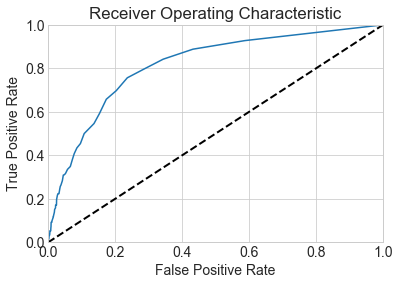

In [33]:
print(roc_auc_score(y_tests[6],gb_probas[6][:,1]))
   
aucroc(gb_probas[6],y_tests[6])

#### Gradient Boost Classifier: 1 quarter/1 mile spray

In [30]:
X_tests[7].columns

Index(['Latitude', 'Longitude', 'dayofyear', 'Species_CULEX ERRATICUS',
       'Species_CULEX PIPIENS', 'Species_CULEX PIPIENS/RESTUANS',
       'Species_CULEX RESTUANS', 'Species_CULEX SALINARIUS',
       'Species_CULEX TARSALIS', 'Species_CULEX TERRITANS', 'Tmax', 'Tmin',
       'Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Depth',
       'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed', '1quarter_1mile'],
      dtype='object')

0.824562779282


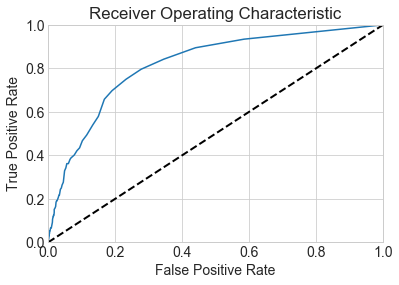

In [31]:
print(roc_auc_score(y_tests[7],gb_probas[7][:,1]))
   
aucroc(gb_probas[7],y_tests[7])

#### Gradient Boost Classifier: 1 quarter/5 mile spray

In [29]:
X_tests[8].columns

Index(['Latitude', 'Longitude', 'dayofyear', 'Species_CULEX ERRATICUS',
       'Species_CULEX PIPIENS', 'Species_CULEX PIPIENS/RESTUANS',
       'Species_CULEX RESTUANS', 'Species_CULEX SALINARIUS',
       'Species_CULEX TARSALIS', 'Species_CULEX TERRITANS', 'Tmax', 'Tmin',
       'Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Depth',
       'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed', '1quarter_5mile'],
      dtype='object')

0.824562779282


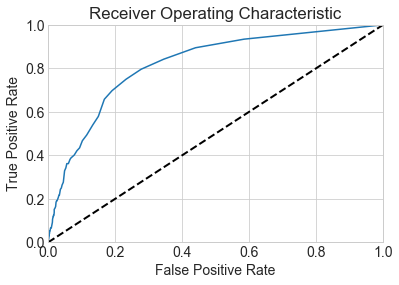

In [25]:
print(roc_auc_score(y_tests[8],gb_probas[8][:,1]))
   
aucroc(gb_probas[8],y_tests[8])

#### Gradient Boost Classifier: NO SPRAY

In [27]:
X_tests[9].columns

Index(['Latitude', 'Longitude', 'dayofyear', 'Species_CULEX ERRATICUS',
       'Species_CULEX PIPIENS', 'Species_CULEX PIPIENS/RESTUANS',
       'Species_CULEX RESTUANS', 'Species_CULEX SALINARIUS',
       'Species_CULEX TARSALIS', 'Species_CULEX TERRITANS', 'Tmax', 'Tmin',
       'Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Depth',
       'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed'],
      dtype='object')

0.822131788065


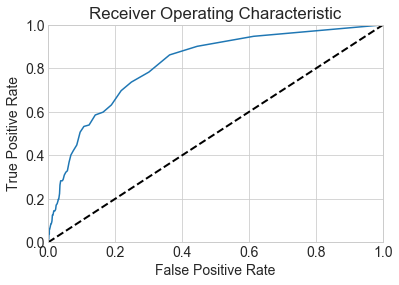

In [28]:
print(roc_auc_score(y_tests[9],gb_probas[9][:,1]))
   
aucroc(gb_probas[9],y_tests[9])

## 4. Scoring

In [10]:
os.chdir('/Users/mjschillawski/Google Drive/Data/generalassembly/projects/west_nile_virus/assets/input')
test_spray = pd.read_csv('spray.csv')
test_weather = pd.read_csv('weather.csv')
test = pd.read_csv('test.csv')

In [11]:
# ## Fix Data
print('munging...')
#train['Date'] = pd.to_datetime(train['Date'])
try:
    test_spray['Date'] = pd.to_datetime(test_spray['Date'])
    test_weather['Date'] = pd.to_datetime(test_weather['Date'])
except:
    pass
test['Date'] = pd.to_datetime(test['Date'])

test_spray['Date'].describe()
test['Date'].describe()
test_weather['Date'].describe()

# ## Drop Duplicates
# inspect duplicates in spray

print(test.duplicated().sum())
test[test.duplicated(keep=False)]

# inspect duplicates in spray
print(test_spray.duplicated(keep=False).sum())
test_spray[test_spray.duplicated(keep=False)][:5]
try:
    test_spray.drop(test_spray[test_spray.duplicated(keep='first')].index,axis=0,inplace=True)
except:
    pass
print(len(test))
print(len(test_spray))
print(len(test_weather))

# ## Fix weather data
# Changes string T to 0.005, M to 0.0 (11 observations of 2944), and everything else into a float
def rainy_day(column):
    try:
        test_weather[column] = test_weather[column].str.replace('T','0.005')
        test_weather[column] = test_weather[column].str.replace('M','0.0')
        test_weather[column] = test_weather[column].astype(float)
    except:
        pass

for col in ['Tavg','PrecipTotal','Depart','WetBulb','SnowFall',
            'StnPressure','SeaLevel','Depth','AvgSpeed','Heat','Cool']:
    rainy_day(col)

#All Tavg values that were missing (changed to 0 with rainy_day function) are given values from min/max
test_weather['Tavg'][test_weather.Tavg==0] = (test_weather['Tmin'] + test_weather['Tmax']) / 2
test_weather['Tavg'].value_counts()

# ## Make numeric
print('make numeric...')
cols = [col for col in test_weather.columns if col not in ('Station','Date')]

bad_col = []

for col in cols:
    try:
        test_weather[col] = pd.to_numeric(test_weather[col])
    except:
        bad_col.append(col)
print(bad_col)

try:
    test_weather.drop('CodeSum',axis=1,inplace=True)
    bad_col.remove('CodeSum')
except:
    pass
    
bad_data = {}

for col in bad_col:
    z = []
    for i in test_weather[col]:
        try:
            pd.to_numeric(i)
        except:
            if i in z:
                pass
            else:
                z.append(i)
    bad_data[col] = z
bad_data

try:
    test_weather[bad_col].describe()

    test_weather.drop(bad_col,axis=1,inplace=True)
except:
    pass

# ## Date Engineering

# need to do something that incorporates date information
# probably categorical?
# other options? seasonal, weekly
# continuous but circular

# continuous, as day of year
test["dayofyear"] = test['Date'].dt.dayofyear

# month
# train['month'] = train['Date'].dt.month

# quarter
# train['quarter'] = train['Date'].dt.quarter

# ## Dummy species
# get dummies for mosquito species

test = pd.get_dummies(test, columns=['Species'])

# ## Join weather data to trap data

print(len(test),len(test_weather))

test_weather.columns

station1 = test_weather[test_weather['Station']==1].copy()
station2 = test_weather[test_weather['Station']==2].copy()

#Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
station1['Latitude'] = 41.995
station1['Longitude'] = -87.9336

#Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level
station2['Latitude'] = 41.78611
station2['Longitude'] = -87.75222

stations = pd.merge(station1,station2,on='Date',suffixes=('_s1','_s2'))
testtrapsweather = pd.merge(test,stations,on='Date')

#DataInspect(testtrapsweather)
print('calculating weather station distance...')
# ## Calculate point estimates of weather data at trap location
# calculate distance of traps to weather stations
dist_1 = np.sqrt(((testtrapsweather['Latitude'] - testtrapsweather['Latitude_s1'])**2 + 
(testtrapsweather['Longitude'] - testtrapsweather['Longitude_s1'])**2))

dist_2 = np.sqrt(((testtrapsweather['Latitude'] - testtrapsweather['Latitude_s2'])**2 + 
(testtrapsweather['Longitude'] - testtrapsweather['Longitude_s2'])**2))

# calculate distance weights to each trap
# to weight the weather data by proximity
total_dist = dist_1 + dist_2
testtrapsweather['weight_1'] = dist_1 / total_dist
testtrapsweather['weight_2'] = dist_2 / total_dist

# Apply distance weights to weather data
# Inverse weight because the closer station should have the heavier weight

station1_list = [col for col in testtrapsweather.columns 
                if '_s1' in col and col not in ('Station_s1','Latitude_s1','Longitude_s1')]
station2_list = [col for col in testtrapsweather.columns 
                if '_s2' in col and col not in ('Station_s2','Latitude_s2','Longitude_s2')]

for col in station1_list:
    testtrapsweather[col] = testtrapsweather['weight_2'] * testtrapsweather[col]
for col in station2_list:
    testtrapsweather[col] = testtrapsweather['weight_1'] * testtrapsweather[col]

testtrapsweather.columns

# we are adding the weighted station1 and station2 weather data
# and dropping the partial columns

for col in [col for col in testtrapsweather.columns 
            if 's1' in col and col not in ('Station_s1','Latitude_s1','Longitude_s1')]:
    name = col.replace('_s1','')
    testtrapsweather[name] = testtrapsweather[col] + testtrapsweather[name+'_s2']
    testtrapsweather.drop([col,name+'_s2'],axis=1,inplace=True)

testtrapsweather.columns

# Drop station information columns
col1 = [col for col in testtrapsweather.columns if '_s1' in col]
col2 = [col for col in testtrapsweather.columns if '_s2' in col]
cols = col1 + col2

testtrapsweather.drop(cols,axis=1,inplace=True)


munging...
0
543
116293
14294
2944
make numeric...
['Sunrise', 'Sunset', 'CodeSum', 'Water1']


/Users/mjschillawski/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


116293 2944
calculating weather station distance...


In [16]:
testtrapsweather = testtrapsweather.drop(['Address','Block','Street','Trap',
       'AddressNumberAndStreet','AddressAccuracy','weight_1',
      'weight_2','Date',],axis=1)

In [19]:
Id = testtrapsweather[['Id']]

In [20]:
testtrapsweather.drop('Id',axis=1,inplace=True)

In [21]:
testtrapsweather['1week_1mile'] = 0

In [25]:
testtrapsweather.drop('Species_UNSPECIFIED CULEX',axis=1,inplace=True)

In [26]:
model_name = 'gb2'
gb_probas = gb_models[1].predict_proba(testtrapsweather)

In [28]:
predictions = pd.DataFrame(gb_probas[:,1],index=Id['Id'])
predictions.rename(columns={0:'WnvPresent'},inplace=True)

In [29]:
path = '/Users/mjschillawski/Google Drive/Data/generalassembly/projects/west_nile_virus/assets/output'
predictions.to_csv(path+'predictions_'+model_name+'.csv')